# Assignment 3

by Nicolás Larrañaga C and Jonathan Alberto Ortiz Rodriguez

In [3]:
import numpy as np
import math

## 1. a


We start by defining an expression that allows us to compute the average distance to the center of mass in the feature space from a set of input data. 

let's redefine the distance as following

$ || \phi(x) - \phi(y) || = \sqrt{ (x1 - x2)^2 + (y1 - y2)^2 } = \sqrt{ -2<x,y> + <x,x> + <y,y>} $

now we can use this distance formula to calculate the average distance to the center of mass as following

$ \frac{1}{n} \sum_{i = 1}^n || \phi(x_i) - \frac{1}{n} \sum_{j = 1} ^ n \phi(x_j) ||  = $

$ \frac{1}{n} \sum_{i = 1}^ n \sqrt{ <\phi(x_i), \phi(x_i)> + \frac{1}{n^2} < \sum_{j = 1}^n \phi(x_j) , \sum_{k =1}^n\phi(x_k) ] - \frac{2}{n} \phi(x_i)\sum_{j = 1}^n \phi(x_j)  }  = $

$ \frac{1}{n} \sum_{i = 1}^n \sqrt{ k(x_i, x_i)  + \frac{1}{n^2} \sum_{j = 1}^n \sum_{k = 1}^n k(x_j,x_k)  - \frac{2}{n} \sum_{j = 1}^n k(x_i,x_j) } $

this expression can be implemented as follows

In [16]:
def average_distance(x, kernel_mat):
    ans = 0.0
    n = x.shape[0]
    for i in range(n):
        tmp1 = kernel_mat[i][i]
        tmp2 = 0.0
        for j in range(n):
            for k in range(n):
                tmp2 += kernel_mat[j][k]
        tmp2 /= (n**2)
        tmp3 = 0.0
        for j in range(n):
            tmp3 += kernel_mat[i][j]
        tmp3 *= 2.0
        tmp3 /= n
        ans += math.sqrt(tmp1 + tmp2 - tmp3)
    return ans/n
        

## 1.b

In [22]:
x = np.array([(0, 1), (-1, 3), (2, 4), (3, -1), (-1, -2)])
n = x.shape[0]
k_1 = [[x[i].dot(x[j]) for i in range(n)] for j in range(n)] # <x,y>
k_2 = [[x[i].dot(x[j])**2 for i in range(n)] for j in range(n)] #<x,y>^2
k_3 = [[(x[i].dot(x[j]) + 1)**5 for i in range(n)] for j in range(n)] #(<x,y> + 1)^5
k_4 = [[math.exp(- np.linalg.norm(x[i] - x[j]) ** 2 / 2.0) for i in range(n)] for j in range(n)] #gaussian kernel with sigma = 1

### i

In [21]:
average_distance( x, k_1 )

699.7672616263939

### ii

In [23]:
average_distance(x, k_2)

7.93374823939363

### iii

In [24]:
average_distance(x, k_3)

699.7672616263939

### iV

In [25]:
average_distance(x, k_4)

0.8899495533798308

# 2 .a

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_mldata('MNIST original')
print(mnist)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


# 2.b

In [2]:
data = np.array(mnist.data).astype(float)
scaled_data = preprocessing.scale(data,copy=False)
print("mean : " , scaled_data.mean())
print("deviation : ",scaled_data.std())
#print(scaled_data)

mean :  -7.739646306420399e-18
deviation :  0.9576491198422709


# 2.c

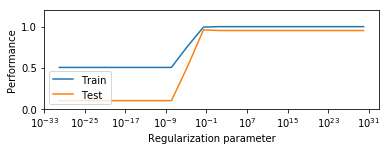

In [3]:
labels = np.array(mnist.target)
tuples = list(zip(labels.astype(int), scaled_data))

d = {}
for key, val in tuples:
    d.setdefault(key, []).append(val)
# dict used to store weights  for each C
weights = {}

def train_svm(number_1, number_2, training_data_percentage=0.8):
    p_train = training_data_percentage
    p_test = 1.0 - p_train

    # getting samples for each class for training and testing
    ones_train_samples = int(len(d[number_1]) * p_train)
    sevens_train_samples = int(len(d[number_2]) * p_train)

    ones_test_samples = len(d[number_1]) - ones_train_samples
    sevens_test_samples = len(d[number_2]) - sevens_train_samples
    
    # getting all images of class 1 ,7 for training 
    ones_train = d[number_1][:ones_train_samples]
    sevens_train = d[number_2][:sevens_train_samples]
    # getting all images of class 1,7 for  testing
    ones_test = d[number_1][ones_train_samples + 1 :]
    sevens_test = d[number_2][sevens_test_samples + 1:]

    #training_data = preprocessing.scale(ones_train + sevens_train)
    #test_data = preprocessing.scale(ones_test + sevens_test)
    training_data = ones_train + sevens_train
    test_data = ones_test + sevens_test
    training_target = [number_1] * len(ones_train) + [number_2] * len(sevens_train)
    test_target = [number_1] * len(ones_test) + [number_2] * len(sevens_test)
    C = np.logspace(-30, 30,20)
    train_error = []
    test_error = []
    for c in C:
        #clf = svm.LinearSVC(C=c)
        clf = SVC(kernel='linear', C=c)
        clf.fit(training_data, training_target)
        train_error.append(clf.score(training_data, training_target))
        test_error.append(clf.score(test_data, test_target))
        weights[c]=clf.coef_
    plt.subplot(2, 1, 1)
    plt.semilogx(C, train_error, label='Train')
    plt.semilogx(C, test_error, label='Test')
    plt.legend(loc='lower left')
    plt.ylim([0, 1.2])
    plt.xlabel('Regularization parameter')
    plt.ylabel('Performance')
    plt.show()
            
train_svm(4, 9, 0.1)

# 2.d
variable **weights** is a dictionary with key C and values are the weights of classifcation , it was filled in the previous step with the **coef_** attribute of SVC

In [4]:
print (weights)

{1e-30: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.000

# 2.e

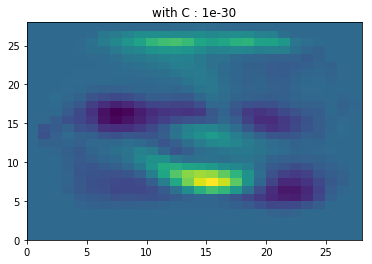

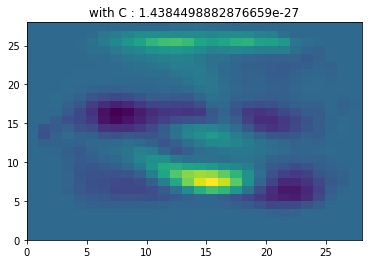

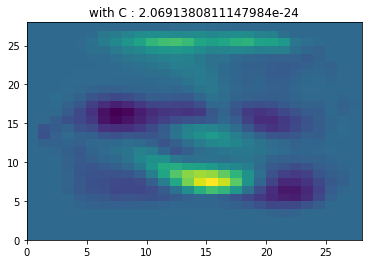

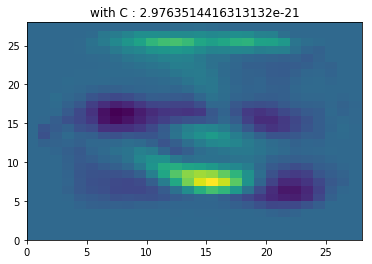

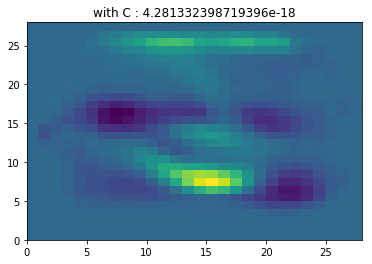

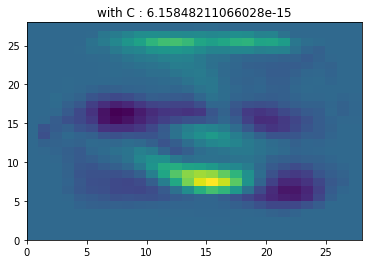

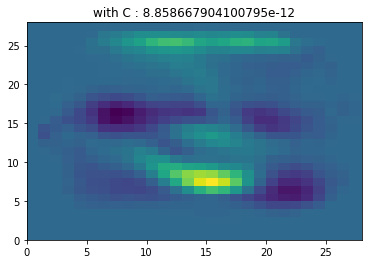

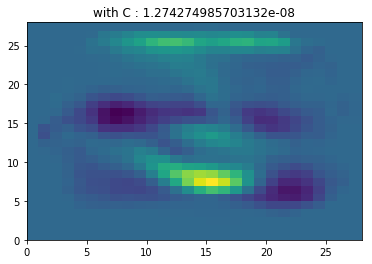

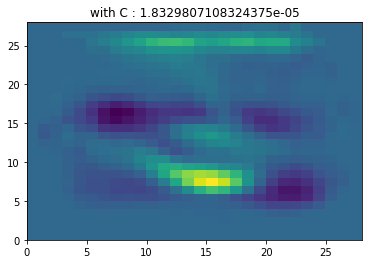

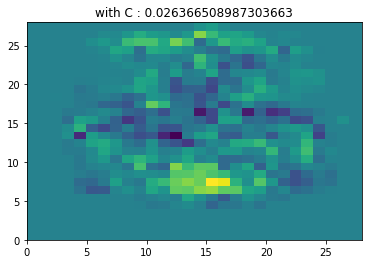

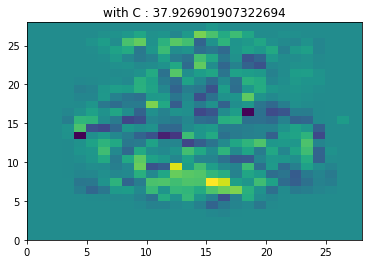

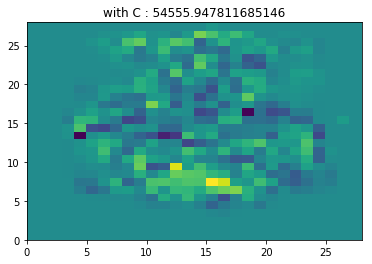

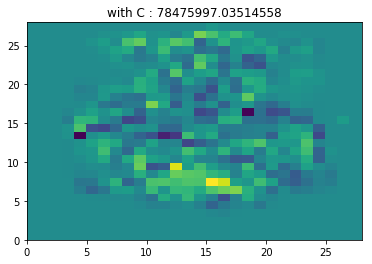

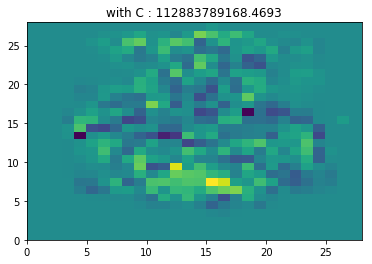

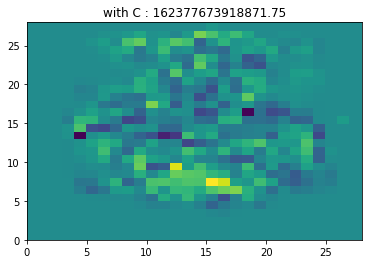

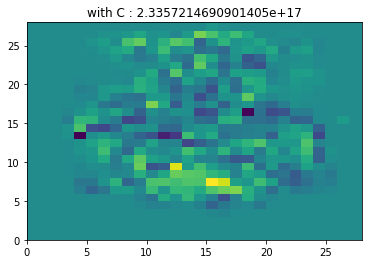

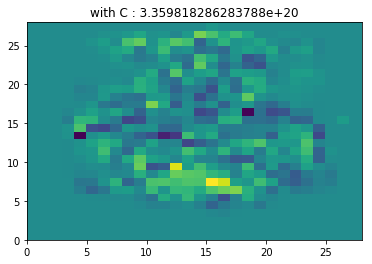

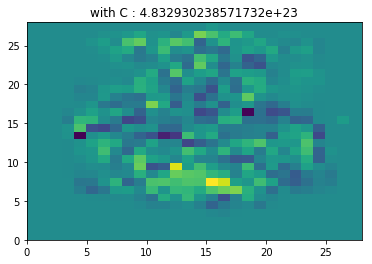

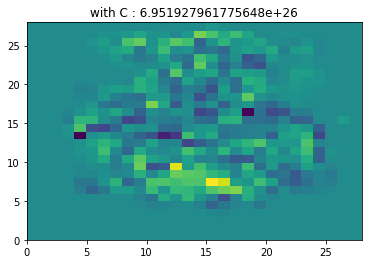

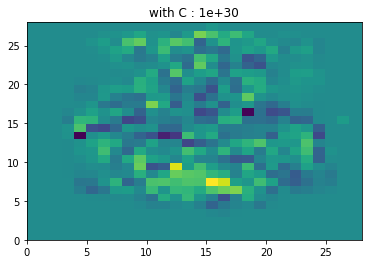

In [5]:
for k,v in weights.items():
    img = v[0].reshape((28,28))
    plt.pcolor(img)
    plt.title("with C : " + str( k))
    plt.show()

# Discussing results 
    - with higher C the machine starts to fit better the digits 
    - SVC do not perfom a good prediction with the data of training is a 50 / 50 at lower C
    - SVC start transitioning from bad to  good predictions in the transition from (10**-9 to 10**-1)
    - SVC does reach a good prediction around (0.1)
    - SVC perfomrs almost the same with C up to 0.1